## Options Pricing

We estimate option prices using implied volatility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
calls = pd.read_csv('calls.csv', index_col=0)
puts = pd.read_csv('puts.csv', index_col=0)

In [3]:
calls

,Mean Price,Bid,Ask,Strike,Current Stock Price,Days to Expiry
0,2305.15,2302.4,2307.9,1000.0,3305.61,1
1,1931.15,1926.2,1936.1,1375.0,3305.61,1
2,1549.55,1547.6,1551.5,1400.0,3305.61,1
3,1715.70,1710.9,1720.5,1425.0,3305.61,1
4,1500.35,1498.4,1502.3,1450.0,3305.61,1
...,...,...,...,...,...,...
301,279.90,274.6,285.2,3300.0,3305.61,701
302,224.95,219.8,230.1,3400.0,3305.61,701
303,176.05,174.9,177.2,3500.0,3305.61,701
304,132.90,128.0,137.8,3600.0,3305.61,701


In [15]:
from scipy.stats import norm

def black_scholes_price(row, call=True):
    #Models price of a put option
    #K: strike price
    #F: forward
    #T: time to expiry
    #sigma: volatility, a model parameter
    S = row['Current Stock Price']
    T = row['Days to Expiry']
    K = row['Strike']
    sigma = row['Implied Volatility']
    d1 = (np.log(S / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    d2 = (np.log(S / K) - 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    return S*norm.cdf(d1)-K*norm.cdf(d2) if call else K*norm.cdf(-d2)-S*norm.cdf(-d1) 

def vega(row):
    #F: spot price
    #K: strike price
    #T: time to maturity
    #sigma: volatility of underlying asset 
    S = row['Current Stock Price']
    T = row['Days to Expiry']
    K = row['Strike']
    sigma = row['Implied Volatility']
    d1 = (np.log(S / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))    
    vega = S * norm.pdf(d1) * np.sqrt(T)    
    return vega

def implied_volatility(S,T,K,P, iterations=1000, initial=1, learning_rate=0.01):
    #computes implied volatility at precision eps
    sigma = initial
    for _ in range(iterations):
        loss = (black_scholes_price(S, T, K, sigma)-P)**2
        sigma -= learning_rate/vega(S,T,K,sigma)
    return sigma
    

In [16]:
for df in [calls, puts]:
    df['Implied Volatility'] = pd.Series(1, index=range(df.shape[0]))
    tol = 0.001
    for _ in range(20):
        df['Black-Scholes Price']  = df.apply(black_scholes_price, axis=1)
        delta = df['Black-Scholes Price'] - df['Mean Price']
        loss = np.sum(delta ** 2) / df.shape[0]
        print(loss)
        if loss<tol:
            break
        df['Vega'] = df.apply(vega, axis=1)
        df['Implied Volatility'] -= delta / df['Vega'] 


5362382.7391511975
8756149.71538611


C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: Runtime

319194.08702725306
141829.3106133672
14012.02112456766
8307.005686689168
7263.44720584264
48149.77990194712
19365.624206986515
32101.431986329597
53.69109778084963
12964.043259349612
1636.3130262837335
63.70468344818935
6320.102351360498
7518.254355980005
813.3501202116807
6330.794288272685
876.7686341917724
6694.371901550342
9004478.55365749
4619807.731989664
246178.32172757515
112165.5783500274
184982.46654210953
46219.83432927994
80720.1056980451
16075.83780207169
133096.40193313808
166236.69162129334
504869.6509936978
354679.70535735105


C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


214913.39447071435
84200.73605495115
104033.94739324875
5082.543360093107
58375.19301570782
0.0014780186087621611
161.57509572354869
26928.439868062775


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X=df['Strike'].to_numpy().reshape(-1,1)

poly = PolynomialFeatures(4)
polynomial_features = poly.fit_transform(X)

y= df['Implied Volatility'].dropna()

reg = LinearRegression()
reg.fit(polynomial_features[df['Implied Volatility'].notna()], y)
ypred= reg.predict(polynomial_features)

df['Implied Volatility'] = ypred
df['Black-Scholes Price'] = df.apply(black_scholes_price, axis=1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [26]:
puts

,Mean Price,Bid,Ask,Strike,Current Stock Price,Days to Expiry
0,0.025,0.0,0.05,1000.0,3294.89,2
1,0.025,0.0,0.05,1100.0,3294.89,2
2,0.025,0.0,0.05,1200.0,3294.89,2
3,0.150,0.0,0.30,1250.0,3294.89,2
4,0.050,0.0,0.10,1300.0,3294.89,2
...,...,...,...,...,...,...
367,132.100,131.1,133.10,2800.0,3294.89,702
368,155.200,154.2,156.20,2900.0,3294.89,702
369,180.950,179.8,182.10,3000.0,3294.89,702
370,321.650,316.4,326.90,3400.0,3294.89,702


In [18]:
import datetime
import time

In [24]:
datetime.date.fromtimestamp(1579219200)-datetime.date.fromtimestamp(time.time())

datetime.timedelta(days=2)

In [1]:
plt.figure(figsize=(13,8)) 
sns.lineplot(data = df, x='strike_price', y='mean_put', label='Actual put price')
sns.scatterplot(data = df, x='strike_price', y='bs_price', label='Estimated put price', color='red', marker='x')
plt.xlabel('Strike price')
plt.ylabel('Put option price')


NameError: name 'plt' is not defined

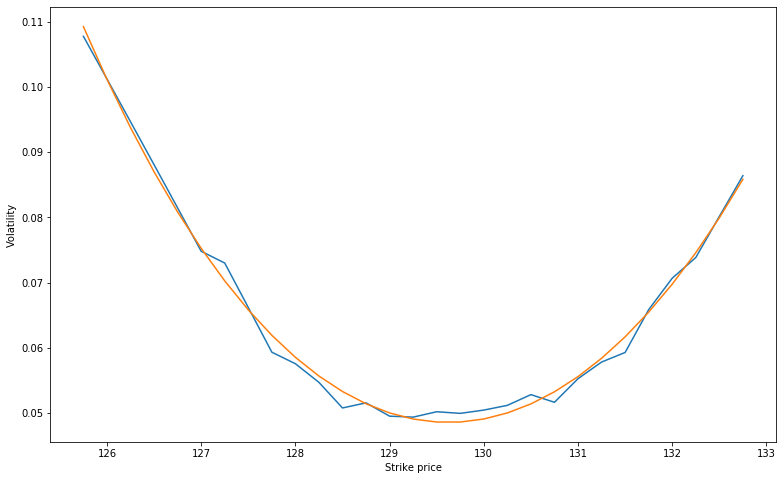

In [160]:
fig = plt.figure(figsize=(13,8)) 
ax = fig.add_subplot()
ax.set_xlabel('Strike price')
ax.set_ylabel('Volatility')
ax.plot(df['strike_price'][y.notna()], y)
ax.plot(df['strike_price'], ypred)